## Tarea 4: Implementación del Algoritmo de ISODATA

Fragoso Alvarado Daniel | 316049054

In [45]:
# ISODATA
import numpy as np
import random
from scipy.spatial import distance
import statistics
from itertools import chain

def isodata(c, X, Y, k, m0, std, lamb, d0, l, N):
    '''
    Función que integra todos los pasos del algoritmo de ISODATA

    Parámetros
    ----------
    c :  Entero:
        Numero entero que describe el numero de grupos que se desean formar.
    
    X : Array
        Son los datos a los que se les aplicará el algoritmo. Es una lista de 
        listas, cada elemento de la lista principal es un punto, todos los puntos
        deberán tener la misma longitud.
    
    Y : Lista de listas
        Son los centroides con los que se determinará la pertenencia de los puntos
        a los grupos.
    
    k : Entero
        Numero de clusters deseados más no mandatorios

    m0 : Entero
        Valor mínimo de patrones perteencientes a un cluster deseado.
    
    std: Float:
        Valor de la desviación estándar de los datos
    
    lamb : Float:
        Valor de refrerencia para generar la partición de los centroides.
    
    d0 :  Float:
        Valor de referencia para geenrar un umbral de agrupamiento.

    l : Entero:
        Valor que indica el numero máximo de pares que deberían de ser agrupados

    N : Entero
        Número de Iteraciones Máximas deseadas.

    Retorna 
    ----------
    Y : Lista
        Lista de listas que contienen los clusters actualizados.

    it :  Entero
        Número de iteraciones hechas en total.
    '''
    # Initial Cluster
    Z = Y
    # Dimensión
    n = X.shape[1]
    # Número de samples
    m = X.shape[0]
    # PASO 1: Inicializar indicadores
    global it
    global S
    global L
    # PASO 2: 
    ## Definamos algunos caracteres

    #INICIO DE LAS ITERACIONES
    
    cn = c
    NC = 1
    # Calculamos la distancia  alos clusters con la función auxiliar:
    labels = get_labels(X, Y)
    # PASO 3
    cont = -1
    for i in range(len(Y)):
        cont += 1
        if labels.count(i) < m0:
            Y = np.delete(Y, cont, 0)
            cont = cont - 1
            c = c - 1
    #if len(Z) < len(Y):
    #    c = c - 1
    ## Recalculamos la asignación:
    labels = get_labels(X, Y)
    # PASO 4
    Y = actualiza_centroides(X, labels, c)

    # diferencia entre viejos clusters
    if cn == c:
        d_clus = 0

        for v in range(len(Y)):
            dist = distance.euclidean(Y[v],Z[v])
            d_clus = d_clus + dist
            
        if d_clus < 0.001:
            NC = 0
    # PASO 5 y 6
    # Calculo de la distancia de cada cluster:
    distancias_promedio, distancia_global = distancia_promedio(X, labels, Y, c)
    # actualizamos numero de iteraciones
    it = it + 1
    print(f'iteración {it}')
    ##################################
    # PASO 7
    if it == N-5:
        # PASO 13
        return Y, it
    # CASO A)
    elif c <= (k + 1)/2:
        # PASO 8
        S[it] = 0
        desv_estd = desviaciones_estd(X, labels, Y, n, c)
        # PASO 9
        if check(desv_estd, std):
            # Si no ocurre el split inciamos casos
            # 1.
            if it > 1 and L[it-1] ==0 and NC == 0:
                return Y,  it
            # 2.
            if it>1 and L[it-1] == 0 and NC == 1:
                # Regresamos de forma recursiva
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
            # 3.
            if it > 1 and L[it-1] != 0:
                # Continuamos 
                #PASO 10
                L[it] = 0
                if c<2 and S[it] == 0 and NC == 0:
                    return Y,  it
                if c<2 and S[it] == 0 and NC == 1:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                if c<2 and S[it] == 2:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                else:
                    # En otro caso vamos a calcular la distancia entre 
                    # clusters
                    dis_cluster = np.zeros((c, c))
                    for i in range(c):
                        for j in range(i+1, c):
                            dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
                    
                    lp = 0
                    for i in range(c):
                        for j in range(i+1, c):
                            if d0 > dis_cluster[i][j]:
                                lp += 1
                    la = min(l, lp)

                    if la == 0:
                        if S[it] == 2:
                            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                        if S[it] == 0:
                            return Y,  it

                    if la != 0:
                        # Continuamos
                        L[it] = 1
                        #solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))

                # PASO 11
                solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
                for i in solutions:
                    yi = np.array(Y[i[0]])
                    yj = np.array(Y[i[1]])

                    mi = labels.count(i[0])
                    mj = labels.count(i[1])

                    Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

                # eliminamos lo viejos clusters
                Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
                c = c - len(solutions)
                
                # Regresamos al paso 2
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)

            # 4.
            # Continuamos
            if it == 1:
                #PASO 10
                L[it] = 0
                if c<2 and S[it] == 0 and NC == 0:
                    return Y,  it
                if c<2 and S[it] == 0 and NC == 1:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                if c<2 and S[it] == 2:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                else:
                    # En otro caso vamos a calcular la distancia entre 
                    # clusters
                    dis_cluster = np.zeros((c, c))
                    for i in range(c):
                        for j in range(i+1, c):
                            dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
                    
                    lp = 0
                    for i in range(c):
                        for j in range(i+1, c):
                            if d0 > dis_cluster[i][j]:
                                lp += 1
                    la = min(l, lp)

                    if la == 0:
                        if S[it] == 2:
                            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                        if S[it] == 0:
                            return Y,  it

                    if la != 0:
                        # Continuamos
                        L[it] = 1
                        #solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))

                # PASO 11
                solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
                for i in solutions:
                    yi = np.array(Y[i[0]])
                    yj = np.array(Y[i[1]])

                    mi = labels.count(i[0])
                    mj = labels.count(i[1])

                    Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

                # eliminamos lo viejos clusters
                Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
                c = c - len(solutions)
                
                # Regresamos al paso 2
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)

        else:
           # Realizamos el Split
            j = round(len(Y)/2)-1
            yj = Y[j]
            Y = np.delete(Y, j, 0)
            i0 = round(n/2) - 1
            yjp = list(yj)
            yjl = list(yj)

            yjp[i0] = yjp[i0] + lamb*desv_estd[j][i0]
            yjl[i0] = yjl[i0] - lamb*desv_estd[j][i0]

            Y = np.append(Y, [yjp], axis=0)
            Y = np.append(Y, [yjl], axis=0)

            c += 1
            S[it] = 1
            # Regresamos al paso 2
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
    # CASO B)

    elif 2*k > c and c > (k+1)/2 and it%2 != 0:
        # PASO 8
        S[it] = 0
        desv_estd = desviaciones_estd(X, labels, Y, n, c)
        
        # PASO 9
        if check(desv_estd, std):
            # Si no ocurre el split inciamos casos
            # 1.
            if it > 1 and L[it-1] ==0 and NC == 0:
                
                return Y,  it
            # 2.
            if it>1 and L[it-1] == 0 and NC == 1:
                # Regresamos de forma recursiva
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
            # 3.
            if it > 1 and L[it-1] != 0:
                # Continuamos 
                #PASO 10
                L[it] = 0
                if c<2 and S[it] == 0 and NC == 0:
                    return Y,  it
                if c<2 and S[it] == 0 and NC == 1:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                if c<2 and S[it] == 2:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                else:
                    # En otro caso vamos a calcular la distancia entre 
                    # clusters
                    dis_cluster = np.zeros((c, c))
                    for i in range(c):
                        for j in range(i+1, c):
                            dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
                    
                    lp = 0
                    for i in range(c):
                        for j in range(i+1, c):
                            if d0 > dis_cluster[i][j]:
                                lp += 1
                    la = min(l, lp)

                    if la == 0:
                        if S[it] == 2:
                            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                        if S[it] == 0:
                            return Y,  it

                    if la != 0:
                        # Continuamos
                        L[it] = 1
                        #solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))

                # PASO 11
                solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
                for i in solutions:
                    yi = np.array(Y[i[0]])
                    yj = np.array(Y[i[1]])

                    mi = labels.count(i[0])
                    mj = labels.count(i[1])

                    Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

                # eliminamos lo viejos clusters
                Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
                c = c - len(solutions)
                
                # Regresamos al paso 2
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)


            # 4.
            # Continuamos
            if it == 1:
                #PASO 10
                L[it] = 0
                if c<2 and S[it] == 0 and NC == 0:
                    return Y,  it
                if c<2 and S[it] == 0 and NC == 1:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                if c<2 and S[it] == 2:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                else:
                    # En otro caso vamos a calcular la distancia entre 
                    # clusters
                    dis_cluster = np.zeros((c, c))
                    for i in range(c):
                        for j in range(i+1, c):
                            dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
                    
                    lp = 0
                    for i in range(c):
                        for j in range(i+1, c):
                            if d0 > dis_cluster[i][j]:
                                lp += 1

                    la = min(l, lp)
                    if la == 0:
                        if S[it] == 2:
                            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                        if S[it] == 0:
                            return Y,  it

                    if la != 0:
                        # Continuamos
                        L[it] = 1
                        solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
                # PASO 11
                for i in solutions:
                    yi = np.array(Y[i[0]])
                    yj = np.array(Y[i[1]])

                    mi = labels.count(i[0])
                    mj = labels.count(i[1])

                    Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

                # eliminamos lo viejos clusters
                Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
                c = c - len(solutions) 

                # Regresamos al paso 2
                isodata(c, X, Y, k, m0, std, lamb, d0, l, N)


        else:
            # Realizamos el Split
            j = round(len(Y)/2)-1
            yj = Y[j]
            Y = np.delete(Y, j, 0)
            i0 = round(n/2) - 1
            yjp = list(yj)
            yjl = list(yj)

            yjp[i0] = yjp[i0] + lamb*desv_estd[j][i0]
            yjl[i0] = yjl[i0] - lamb*desv_estd[j][i0]

            Y = np.append(Y, [yjp], axis=0)
            Y = np.append(Y, [yjl], axis=0)

            c += 1
            S[it] = 1
            # Regresamos al paso 2
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
    # CASO C)
    elif c >= 2*k:
        #PASO 10
        L[it] = 0
        if c<2 and S[it] == 0 and NC == 0:
            return Y,  it
        if c<2 and S[it] == 0 and NC == 1:
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
        if c<2 and S[it] == 2:
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
        else:
            # En otro caso vamos a calcular la distancia entre 
            # clusters
            dis_cluster = np.zeros((c, c))
            for i in range(c):
                for j in range(i+1, c):
                    dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
            
            lp = 0
            for i in range(c):
                for j in range(i+1, c):
                    if d0 > dis_cluster[i][j]:
                        lp += 1
            la = min(l, lp)

            if la == 0:
                if S[it] == 2:
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                if S[it] == 0:
                    return Y,  it

            if la != 0:
                # Continuamos
                L[it] = 1
                #solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))

        # PASO 11
        solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
        for i in solutions:
            yi = np.array(Y[i[0]])
            yj = np.array(Y[i[1]])

            mi = labels.count(i[0])
            mj = labels.count(i[1])

            Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

        # eliminamos lo viejos clusters
        Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
        c = c - len(solutions)
        
        # Regresamos al paso 2
        isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
    # CASO D)
    elif 2*k > c and c > (k+1)/2 and it%2 == 0:
        #PASO 10
        L[it] = 0
        if c<2 and S[it] == 0 and NC == 0:
            return Y,  it
        if c<2 and S[it] == 0 and NC == 1:
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
        if c<2 and S[it] == 2:
            isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
        else:
            print('Distancias clusters')
            # En otro caso vamos a calcular la distancia entre 
            # clusters
            dis_cluster = np.zeros((c, c))
            for i in range(c):
                for j in range(i+1, c):
                    dis_cluster[i, j] = distance.euclidean(Y[i],Y[j])
            
            lp = 0
            for i in range(c):
                for j in range(i+1, c):
                    if d0 > dis_cluster[i][j]:
                        lp += 1
            la = min(l, lp)

            if la == 0:
                if S[it] == 2:
                    print('Entra en ==2')
                    isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
                print(S[it])
                if S[it] == 0:
                    print('Entra en ==0')
                    return Y,  it

            if la != 0:
                print('Entra en dif 0')
                # Continuamos
                L[it] = 1
                #solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))

        # PASO 11
        print('Paso 11')
        solutions = np.argwhere((dis_cluster < d0) & (dis_cluster > 0))
        for i in solutions:
            yi = np.array(Y[i[0]])
            yj = np.array(Y[i[1]])

            mi = labels.count(i[0])
            mj = labels.count(i[1])

            Y = np.append(Y, [((mi*yi + mj*yj)/(mi+mj))], axis=0)

        # eliminamos lo viejos clusters
        Y = np.delete(Y, list(chain.from_iterable(solutions)), 0)
        c = c - len(solutions)
        
        # Regresamos al paso 2
        isodata(c, X, Y, k, m0, std, lamb, d0, l, N)

    # PASO 12 O 13
    return Y,  it
    

In [29]:
def get_labels(datos, centroides):
  '''
  Función auxiliar para el algoritmo de ISODATA que genera la clasificación de 
  los patrones egú el centroide que tenga más cerca.

  Parámetros
  ----------
  datos : Lista de listas
    Son los datos a los que se les aplicará el algoritmo. Es una lista de 
    listas, cada elemento de la lista principal es un punto, todos los puntos
    deberán tener la misma longitud.

  centroides : Lista de listas
    Son los centroides con los que se determinará la pertenencia de los puntos
    a los grupos.

  Retorna 
  ----------
  labels : Lista
    Es una lista que indica el grupo al que pertenece cada punto, ordenado
    según el orden original de los datos. Se consideran los grupos 0, 1,..., k-1 
  '''
  labels = []
  for punto in datos:
    min_dist = float('inf')
    label = None

    for i, centroide in enumerate(centroides):
      nueva_dist = distance.euclidean(punto,centroide)
      if min_dist > nueva_dist:
        min_dist = nueva_dist
        label = i
    labels.append(label)
  return labels

def actualiza_centroides(datos, labels, k):

  '''
  Función auxiliar para el algoritmo de ISODATA que calcula los nuevos centroides
  a partir de las etiquetas y los datos caluclando el valor medio para cada 
  cluster.

  Parámetros
  ----------
  datos : Lista de listas
    Son los datos a los que se les aplicará el algoritmo. Es una lista de 
    listas, cada elemento de la lista principal es un punto, todos los puntos
    deberán tener la misma longitud.

  labels : Lista
    Es una lista que indica el grupo al que pertenece cada punto, ordenado
    según el orden original de los datos. Se consideran los grupos 0, 1,..., k-1 

  k : Entero
    Es la cantidad de grupos en que se quiere dividir el conjunto de datos.

  Retorna 
  ----------
  nuevos_centroides : Lista de listas
    Devuelve los centroides recalculados según los datos y su grupo de
    pertenencia según su label.
  '''
  dim = datos.shape[1]
  nuevos_centroides = [[0]*dim for i in range(k)]
  contador = [0]*k 

  for punto, label in zip(datos,labels):
    for i in range(dim):
      nuevos_centroides[label][i] += punto[i]
    contador[label] += 1

  for i in range(k):
    nuevos_centroides[i] = list(np.array(nuevos_centroides[i])/contador[i])

  return nuevos_centroides

def distancia_promedio(datos, labels, centroides, c):
  '''
  Función auxiliar para el algoritmo ISODATA que calcula la distancia promedio de 
  cada patrón de un grupo a su respectivo cluster y la distancia global, que es
  la distancia promedio de las distancias promedio. 

  Parámetros
  ----------
  datos : Array
    Son los datos a los que se les aplicará el algoritmo. Es una lista de 
    listas, cada elemento de la lista principal es un punto, todos los puntos
    deberán tener la misma longitud.
  
  labels : Lista
    Es una lista que indica el grupo al que pertenece cada patrón.

  centroides : Lista de listas
    Son los centroides con los que se determinará la pertenencia de los puntos
    a los grupos.

  c : Entero
    Es un número entero que indica la cantidad de grupos que se tienen

  Retorna 
  ----------
  dis_pro : Lista
    Lista de valores flotantes que indica la distacia promedio para cada 
    centroide
  sum(dis_global)/len(datos) : Float
    Valor flotante que indica la distancia global 
  '''
  dis_pro = []
  dis_global = []
  for i in range(c):
    index = np.where(np.array(labels) == i)
    xi = datos[index]
    distancia = []
    for j in range(len(xi)):
      distancia.append(distance.euclidean(xi[j],centroides[i]))
    dis_pro.append(statistics.mean(distancia))
    dis_global.append(len(distancia)*statistics.mean(distancia))
  return dis_pro, sum(dis_global)/len(datos)
  
def desviaciones_estd(datos, labels, centroides, n, c):
  '''
  Función auxiliar para el algoritmo ISODATA que calcula los vectores de centroides 
  para cada grupo. 

  Parámetros
  ----------
  datos : Array
    Son los datos a los que se les aplicará el algoritmo. Es una lista de 
    listas, cada elemento de la lista principal es un punto, todos los puntos
    deberán tener la misma longitud.
  
  labels : Lista
    Es una lista que indica el grupo al que pertenece cada patrón.

  centroides : Lista de listas
    Son los centroides con los que se determinará la pertenencia de los puntos
    a los grupos.

  n : Entero
    Es la dimensión del proiblemq

  c : Entero
    Es un número entero que indica la cantidad de grupos que se tienen

  Retorna 
  ----------
  dis_pro : Lista
    Lista de valores flotantes que indica la distacia promedio para cada 
    centroide
  sum(dis_global)/len(datos) : Float
    Valor flotante que indica la distancia global 
  '''
  des_etd = []

  for i in range(c):
    index = np.where(np.array(labels) == i)
    xi = datos[index]
    vec = []
    for n0 in range(n):
      distancia = []
      for j in range(len(xi)):
        distancia.append((xi[j][n0] - centroides[i][n0])**2)
      vec.append(statistics.mean(distancia)**0.5)
    des_etd.append(vec)

  return des_etd

def check(list1, val):
  '''
  Función auxiliar para el algoritmo ISODATA que cverifica si existe un 
  valor de una lista que sea menor que un numero fijo.

  Parámetros
  ----------
  list1 : Array
    Lista con los datos que queremos comprobar
  
  var : Float
    Valor flotante que sirve como filtro

  Retorna 
  ----------
  True : Boleano
    Regresa un verdadero en caos de que ningun valor de list1 arrebase val
  False : Booleano 
    Regresa Falso en caso contrario al anetrior
  '''
  for x in list1:
    for y in x:
      if val<= y:
         return False 
  return True
  

In [30]:
# Definimos la función final:
def ISODATA_A(c, X, Y, k, m0, std, lamb, d0, l, N):
    '''
    Función que permite la identificación de variables globales necesarias
    para la estructura del algoritmo.

    Parámetros
    ----------
    c :  Entero:
        Numero entero que describe el numero de grupos que se desean formar.
    
    X : Array
        Son los datos a los que se les aplicará el algoritmo. Es una lista de 
        listas, cada elemento de la lista principal es un punto, todos los puntos
        deberán tener la misma longitud.
    
    Y : Lista de listas
        Son los centroides con los que se determinará la pertenencia de los puntos
        a los grupos.
    
    k : Entero
        Numero de clusters deseados más no mandatorios

    m0 : Entero
        Valor mínimo de patrones perteencientes a un cluster deseado.
    
    std: Float:
        Valor de la desviación estándar de los datos
    
    lamb : Float:
        Valor de refrerencia para generar la partición de los centroides.
    
    d0 :  Float:
        Valor de referencia para geenrar un umbral de agrupamiento.

    l : Entero:
        Valor que indica el numero máximo de pares que deberían de ser agrupados

    N : Entero
        Número de Iteraciones Máximas deseadas.

    Retorna 
    ----------
    pru : Lista
        Lista de listas que contienen los clusters actualizados.
    
    labels : Lista
        Lista que contiene el grupo de pertenencia de cada patrón.

    itp :  Entero
        Número de iteraciones hechas en total.
    '''
    # Definimos las variables globales:
    global it
    global S
    global L
    
    it = 0
    S = [2]*N
    L = [2]*N

    # Aplicamos el algoritmo:
    pru, itp = isodata(c, X, Y, k, m0, std, lamb, d0, l, N)
    # Calculamos los grupos para cada patrón
    labels = get_labels(X, pru)

    return pru, labels, itp

    

## Ejercico:

### 1

In [31]:
# Definimos los datos

X = [[0, 0], [1, 0], [1, 1], [0, 1], [4, 1], [5, 1], [5, 2], [7, 1], [7, 2], [6, 3], [2, 3], [1, 4], [2, 5], [3, 5]]
Y = [[0, 0], [4, 1], [7, 2], [2, 3], [3, 5]]

X = np.array(X)
Y = np.array(Y)

c = 5
k = 3
m0 = 2
std = 1.5
lamb = 0.5
d0 = 2.5 
l = 2
N = 10

In [32]:
# Aplicamos nuestro algoritmo

pru, labes, itp = ISODATA_A(c, X, Y, k, m0, std, lamb, d0, l, N)

iteración 1
iteración 2
Distancias clusters
Entra en ==2
iteración 3
0
Entra en ==0


Resultados:

In [33]:
pru

array([[0.5       , 0.5       ],
       [5.66666667, 1.66666667],
       [2.        , 4.25      ]])

In [34]:
labes

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]

In [35]:
itp

3

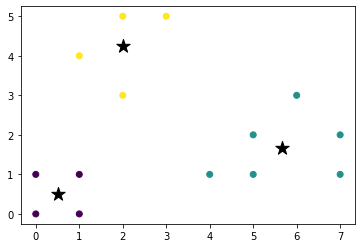

In [59]:
# Gráfica

import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c = labes)
plt.scatter(pru[:, 0], pru[:, 1], marker = '*', s=200, c = 'k')

### Preguntas

- ¿Es correcto?

Aqui depende de que es lo que vemos como correcto; dado que es un algoritmo bastante flexible, hace que el resultado no es del todo controlado por nosotros. Por lo que no siempre se va atener una agrupación óptima, sin embargo, arrojará una agrupación, y en ese sentido es correcto.

- Complejidad en tiempo

En el peor de los casos, el algoritmo se ejecuta en la totalidad de los paosos:

Primero se asignan los valores para calcular los labels, así que se deben de calcular |X| * c, donde |X| es la cantidad de datos, y c los clusters iniciales.

Posteriormente se hace el calculo promedio para cada grupo, considerando a cada promedio como una operecaión solo se realizan entonces: c

El calculo de las distancias promedio toma entonces c, y la distancia global solo una operación más: 1

Sigue el calculo de la desviación estándar que depende de la dimensión y se aplica para cada valor : n * |X|

Digamoos que el proceso de Splitting solo toma una operación; posteriormente digamos que el proceso de lumpiing toma las distancias de cluster por cluster c*(c-1).

El último paso solo toma una operación.

En el peor de los casos se hace por c = 2k

$$O(|X|*2k + 2k + n * |X| + 2k * (2k))$$

Y a su vez se va a ejecutar ene l peor de los casos por el total de iteraciones N:

$$O(N(|X|*2k + 2k + n * |X| + 2k * (2k-1)))$$

Reducimos:

$$O(N(|X|(2k +  n ) + 1))$$

- Complejidad es Espacio

Al final solo guardamos los centroides actualziados, el grupo al que pertenece cada dato, y algunas listas del tamaño de los datos más, así que la complejidad es pacio es:

$$
O(N + k)
$$

- ¿Existen regiones indeterminadas?

Sí, bajo ciertos parámetros y por la forma en que se implemento el algoritmo; con parámetros mal elegidos el algoritmo puede entrar en un bucle infinito, que debería de detenerse a las N iteraciones, y aun así no va a dar valores para los centroides correctamente. 

#### Opinión:

El algoritmo es muy simmilar a k-medias, de hecho ocupa parte de las funciones que usariamos en k medias, sin embargo, los procesos de agrupamiento, separación, son más complejos; no podría decir cual es mejor, pero sí que la implementación de ISODATA es mucho más compleja, y además es muy suceptible a los parámetros iniciales, lo que a veces puede generar que no sea del todo óptimo o correcta, aun más, los parámetros iniciales deben de ser calculados, y puede ser más complicado que solo calcular el valor k, que es la única suposición importante dentro de la implementación de k-medias.

Personalmente no me parece un algoritmo que valga la pena usar, habiendo uno mucho más óptimo como k-medias que provee resultados muy similares. Audemás mencionar que la implemnetación fue muy bruzca y directa y sin duda, se podría óptimizar y mejorar en un futuro.